# Accident Model
## Author: Gary Corcoran
## Date: Dec. 24th, 2017

Binary Classification of Car Accidents from vehicle dashcam videos.


### Read Input Data
Input data is stored in a numpy matrix consisting of each RGB image resized to $(100\times100)$

X_train: (1050, 100, 100, 3) y_train: (1050,)
X_val: (350, 100, 100, 3) y_val: (350,)
X_test: (350, 100, 100, 3) y_test: (350,)


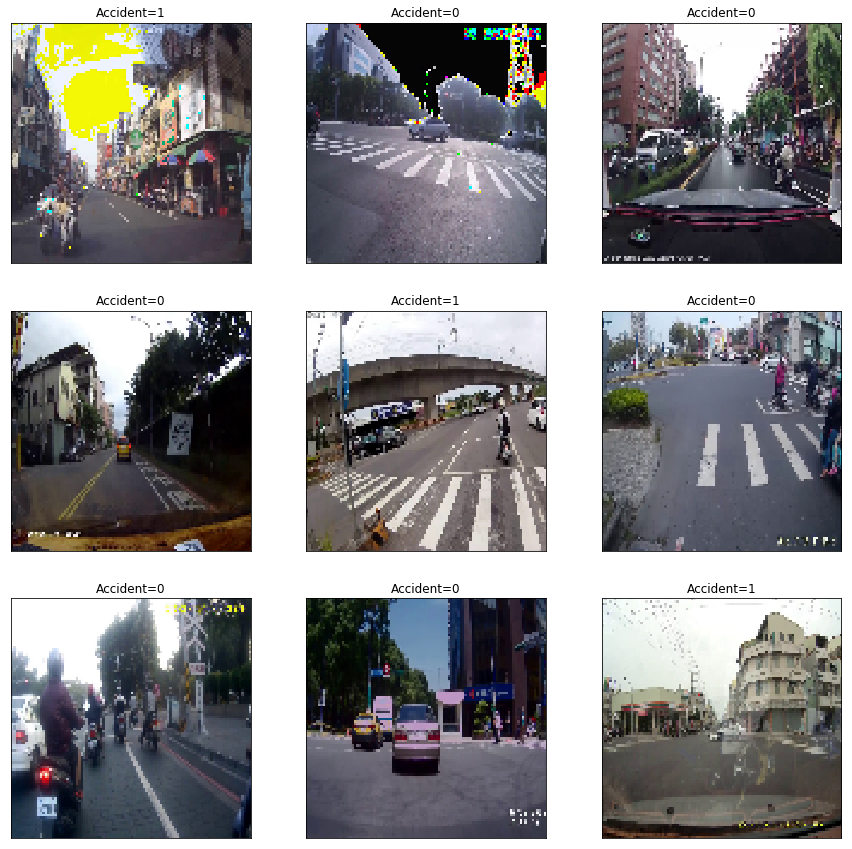

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# display inline figures
%matplotlib inline

# data manipulation helpers
def shuffle_numpy(X, y):
    """
    Shuffle Input Matrices.
    
    @param X: input data matrix [num_instances x row x col x num_channels]
                @pre numpy matrix
    @param y: input labels matrix [num_instances]
                @pre numpy matrix
                
    @return shuffled data
    """
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def split_data(X, y):
    """
    Split Dataset.
    
    @param X: input data matrix [num_instances x row x col x num_channels]
                @pre numpy matrix
    @param y: input labels matrix [num_instances]
                @pre numpy matrix
                
    @return training, validation and test datasets
    """
    X_train, X_val, X_test = np.split(X, [int(0.6*len(X)), int(0.8*len(X))])
    y_train, y_val, y_test = np.split(y, [int(0.6*len(y)), int(0.8*len(y))])
    print('X_train:', X_train.shape, 'y_train:', y_train.shape)
    print('X_val:', X_val.shape, 'y_val:', y_val.shape)
    print('X_test:', X_test.shape, 'y_test:', y_test.shape)
    training_data = X_train, y_train
    validation_data = X_val, y_val
    test_data = X_test, y_test
    return training_data, validation_data, test_data

# read input data
data_path = '../data/'
# X is dimensions [num_instances x width x height x num_channels] 
X = np.load(data_path + 'X.npy')
# y is dimensions [num_instances x 2] (0 = no accident, 1 = accident)
y = np.load(data_path + 'y.npy')
# shuffle data
X, y = shuffle_numpy(X, y)
# split data
training_data, validation_data, test_data = split_data(X, y)
X_train, y_train = training_data
X_val, y_val = validation_data
X_test, y_test = test_data
# number of examples
n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)
# display random training examples
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.title('Accident=' + str(y_train[i]))
    plt.xticks([]), plt.yticks([])
plt.show()

### Build the Model: Feed-Forward NN
First start off with a simple fully-connected neural network.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FullyConnectedNN(nn.Module):
    """
    Fully Connected Neural Network Model.
    
    @param n_inputs: number of input neurons
    @param n_hidden: number of hidden neurons
    @param n_outputs: number of output neurons
    @param activation: activation function
    """
    def __init__(self, n_inputs, n_hidden, n_outputs, activation=nn.Sigmoid()):
        """
        Initialize parameters and layers.
        """
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.activation = activation
        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_outputs)
    
    def forward(self, x):
        """
        Forward pass through network.
        
        @param x: input data
        
        @return output predictions
        """
        # [batch_size x feature_dimension]
        x = x.view(-1, self.n_inputs)
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out

# create network
net = FullyConnectedNN(n_inputs=100*100*3, n_hidden=50, n_outputs=2,
                       activation=nn.Sigmoid())
print(net)

FullyConnectedNN (
  (activation): Sigmoid ()
  (fc1): Linear (30000 -> 50)
  (fc2): Linear (50 -> 2)
)


### Train the Model
Simple stochastic gradient-descent optimiziation.

Epoch 0
	Training Loss: 68.47865405678749
	Training Accuracy: 63.42857142857142
	Validation Accuracy: 65.42857142857143
Epoch 1
	Training Loss: 67.2807340323925
	Training Accuracy: 64.66666666666666
	Validation Accuracy: 64.28571428571429
Epoch 2
	Training Loss: 66.74064257740974
	Training Accuracy: 65.14285714285715
	Validation Accuracy: 62.57142857142857
Epoch 3
	Training Loss: 66.281832665205
	Training Accuracy: 64.85714285714286
	Validation Accuracy: 62.57142857142857
Epoch 4
	Training Loss: 65.84223192930222
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 60.857142857142854
Epoch 5
	Training Loss: 65.402258425951
	Training Accuracy: 65.52380952380953
	Validation Accuracy: 60.285714285714285
Epoch 6
	Training Loss: 64.95333588123322
	Training Accuracy: 65.14285714285715
	Validation Accuracy: 59.42857142857143
Epoch 7
	Training Loss: 64.4887974858284
	Training Accuracy: 66.0952380952381
	Validation Accuracy: 58.857142857142854
Epoch 8
	Training Loss: 64.00315403938293
	T

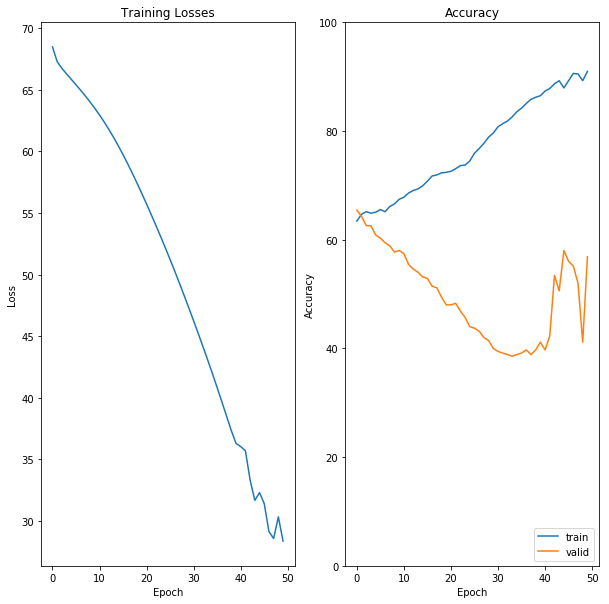

In [3]:
import time

def train(network, num_epochs, learning_rate, batch_size, loss_fn,
          optimizer):
    # statistics
    training_losses = []
    training_accuracies = []
    validation_accuracies = []
    # train
    for epoch in range(num_epochs):
        print('Epoch', epoch)
        running_loss = 0.0
        train_correct = 0
        val_correct = 0
        # generator to loop through mini-batches
        mini_batch = ((X_train[k:k+batch_size], y_train[k:k+batch_size])
                     for k in range(0, n_train, batch_size))
        # each mini-batch
        for x_batch, y_batch in mini_batch:
            inputs = Variable(torch.from_numpy(x_batch))
            targets = Variable(torch.from_numpy(y_batch))

            # forward, backward and optimize
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            # prediction
            _, y_pred = torch.max(outputs, 1)
            train_correct += torch.sum((y_pred.data==targets.data).int())
            running_loss += loss.data[0]

        # training loss
        training_losses.append(running_loss)
        print('\tTraining Loss:', running_loss)
        # training accuracy
        acc = train_correct / n_train * 100
        training_accuracies.append(acc)
        print('\tTraining Accuracy:', acc)
        
        # validation accuracy
        mini_batch = ((X_val[k:k+batch_size], y_val[k:k+batch_size])
                     for k in range(0, n_val, batch_size))
        for x_batch, y_batch in mini_batch:
            inputs = Variable(torch.from_numpy(x_batch))
            targets = Variable(torch.from_numpy(y_batch))
            # forward pass
            outputs = net(inputs)
            # prediction
            _, y_pred = torch.max(outputs, 1)
            val_correct += torch.sum((y_pred.data==targets.data).int())    
        acc = val_correct / n_val * 100
        validation_accuracies.append(acc)
        print('\tValidation Accuracy:', acc)
    
    return training_losses, training_accuracies, validation_accuracies

# hyper-parameters
num_epochs = 50
learning_rate = 0.01
batch_size = 10
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), learning_rate)
# start timer
start = time.time()
train_losses, train_acc, valid_acc = train(net, num_epochs, learning_rate, 
                                           batch_size, criterion, optimizer)
print('Elapsed Time:', time.time()-start)

# plot figures
plt.figure(figsize=(10,10))
plt.subplot(121), plt.plot(train_losses)
plt.title('Training Losses'), plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.subplot(122)
plt.plot(train_acc, label='train'), plt.plot(valid_acc, label='valid')
plt.ylim(0, 100)
plt.title('Accuracy'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Improved Model: CNN
Basic Convolutional Neural Network

In [17]:
class CNN(nn.Module):
    """
    Convolutional Neural Network.
    
    @params
    """
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*22*22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
    
    def forward(self, x):
        """
        Forward pass through network.
        
        @param x: input data
        
        @return output predictions
        """
        x = x.view(-1, *self.input_size)
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 16*22*22)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        
# create network
net = CNN(input_size=(3, 100, 100))

### Train Improved Model
Using Adam gradient descent.

Epoch 0
	Training Loss: 69.29188284277916
	Training Accuracy: 64.47619047619048
	Validation Accuracy: 65.71428571428571
Epoch 1
	Training Loss: 68.49183279275894
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 65.71428571428571
Epoch 2
	Training Loss: 68.40048635005951
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 65.71428571428571
Epoch 3
	Training Loss: 68.29536011815071
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 65.71428571428571
Epoch 4
	Training Loss: 67.99516597390175
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 65.71428571428571
Epoch 5
	Training Loss: 67.56456017494202
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 65.71428571428571
Epoch 6
	Training Loss: 67.14625206589699
	Training Accuracy: 65.04761904761904
	Validation Accuracy: 65.71428571428571
Epoch 7
	Training Loss: 66.6971689760685
	Training Accuracy: 65.14285714285715
	Validation Accuracy: 64.0
Epoch 8
	Training Loss: 65.54266881942749
	Training Ac

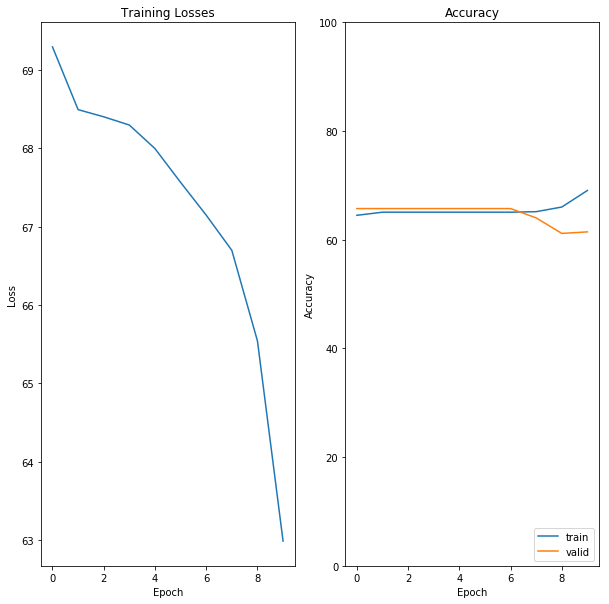

In [19]:
# hyper-parameters
num_epochs = 10
learning_rate = 0.001
batch_size = 10
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)
# start timer
start = time.time()
train_losses, train_acc, valid_acc = train(net, num_epochs, learning_rate, 
                                           batch_size, criterion, optimizer)
print('Elapsed Time:', time.time()-start)

# plot figures
plt.figure(figsize=(10,10))
plt.subplot(121), plt.plot(train_losses)
plt.title('Training Losses'), plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.subplot(122)
plt.plot(train_acc, label='train'), plt.plot(valid_acc, label='valid')
plt.ylim(0, 100)
plt.title('Accuracy'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### References:
1. http://neuralnetworksanddeeplearning.com/index.html
2. http://pytorch.org/tutorials/    